# Sentiment Analysis using LSTM

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
import random
import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.12.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd gdrive/My Drive/571T/project

Mounted at /content/gdrive
/content/gdrive/My Drive/571T/project


In [ ]:
df_train = pd.read_csv('./train.csv', encoding = 'latin',header=None)
df_test = pd.read_csv('./test.csv', encoding = 'latin',header=None)

df_train, df_validation = train_test_split(df_train, test_size=0.2,
                                         random_state=7) # Splits Dataset into train and validation set

print("Train Data size:", len(df_train))
print(df_train.head())
print()
print("Validation Data size:", len(df_validation))
print(df_validation.head())
print()
print("Test Data size", len(df_test))
print(df_test.head())

Train Data size: 448000
        0                                                  1
230889  1  You know for a local eatery ok...but as a dest...
533288  2  I think they deserve the 4 stars just for all ...
25810   2  The neighborhood does not do justice to the ge...
182013  1  I would love to rate this higher but three str...
519283  2  MJ legendary\n\nThis show was pretty amazing. ...

Validation Data size: 112000
        0                                                  1
191465  1  I was severely disappointed in this place. Fir...
238738  2  A few days ago my favorite restaurant blogger,...
276165  2  This is by far the best place in my area for g...
60284   1  The atmosphere and decor are cool. The service...
152976  1  Buffet of Buffets: Stop #1: Brunch\n\nWhy is i...

Test Data size 38000
   0                                                  1
0  2  Contrary to other reviews, I have zero complai...
1  1  Last summer I had an appointment to get new ti...
2  2  Friendly staff, sa

In [ ]:
df_train.columns = ['sentiment', 'content']
df_train.head()

,sentiment,content
230889,1,You know for a local eatery ok...but as a dest...
533288,2,I think they deserve the 4 stars just for all ...
25810,2,The neighborhood does not do justice to the ge...
182013,1,I would love to rate this higher but three str...
519283,2,MJ legendary\n\nThis show was pretty amazing. ...


In [ ]:
df_validation.columns = ['sentiment', 'content']
df_validation.head()

,sentiment,content
191465,1,I was severely disappointed in this place. Fir...
238738,2,"A few days ago my favorite restaurant blogger,..."
276165,2,This is by far the best place in my area for g...
60284,1,The atmosphere and decor are cool. The service...
152976,1,Buffet of Buffets: Stop #1: Brunch\n\nWhy is i...


In [ ]:
df_test.columns = ['sentiment', 'content']
df_test.head()

,sentiment,content
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [ ]:
label_to_sentiment = {1:"Negative", 2:"Positive"}
def label_decoder(number):
  return label_to_sentiment[number]

In [ ]:
df_train.sentiment = df_train.sentiment.apply(lambda x: label_decoder(x))
df_train.head()

,sentiment,content
230889,Negative,You know for a local eatery ok...but as a dest...
533288,Positive,I think they deserve the 4 stars just for all ...
25810,Positive,The neighborhood does not do justice to the ge...
182013,Negative,I would love to rate this higher but three str...
519283,Positive,MJ legendary\n\nThis show was pretty amazing. ...


In [ ]:
df_validation.sentiment = df_validation.sentiment.apply(lambda x: label_decoder(x))
df_validation.head()

,sentiment,content
191465,Negative,I was severely disappointed in this place. Fir...
238738,Positive,"A few days ago my favorite restaurant blogger,..."
276165,Positive,This is by far the best place in my area for g...
60284,Negative,The atmosphere and decor are cool. The service...
152976,Negative,Buffet of Buffets: Stop #1: Brunch\n\nWhy is i...


In [ ]:
df_test.sentiment = df_test.sentiment.apply(lambda x: label_decoder(x))
df_test.head()

,sentiment,content
0,Positive,"Contrary to other reviews, I have zero complai..."
1,Negative,Last summer I had an appointment to get new ti...
2,Positive,"Friendly staff, same starbucks fair you get an..."
3,Negative,The food is good. Unfortunately the service is...
4,Positive,Even when we didn't have a car Filene's Baseme...


Text(0.5, 1.0, 'Trainset Sentiment Data Distribution')

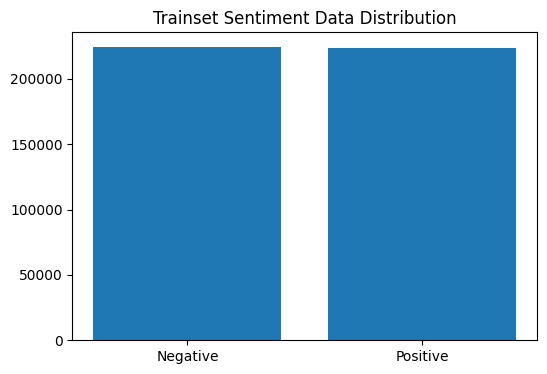

In [ ]:
train_val_count = df_train.sentiment.value_counts()
plt.figure(figsize=(6,4))
plt.bar(train_val_count.index, train_val_count.values)
plt.title("Trainset Sentiment Data Distribution")

Text(0.5, 1.0, 'Validation set Sentiment Data Distribution')

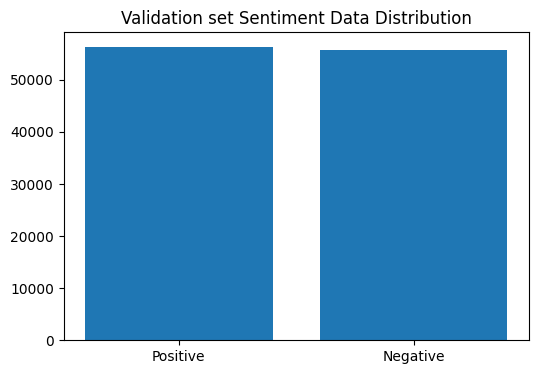

In [ ]:
validation_val_count = df_validation.sentiment.value_counts()
plt.figure(figsize=(6,4))
plt.bar(validation_val_count.index, validation_val_count.values)
plt.title("Validation set Sentiment Data Distribution")

Text(0.5, 1.0, 'Testset Sentiment Data Distribution')

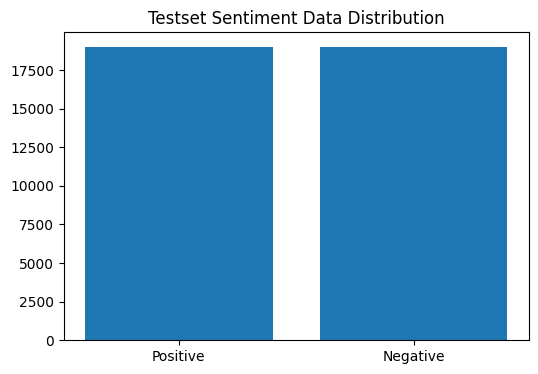

In [ ]:
test_val_count = df_test.sentiment.value_counts()
plt.figure(figsize=(6,4))
plt.bar(test_val_count.index, test_val_count.values)
plt.title("Testset Sentiment Data Distribution")

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.content)

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("The 10 most frequent words in df_train.content:")
print(dict(list(word_index.items())[0:10]))
print("Vocabulary Size :", vocab_size)

The 10 most frequent words in df_train.content:
{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'was': 6, 'of': 7, 'it': 8, 'for': 9, 'in': 10}
Vocabulary Size : 223073


In [ ]:
MAX_SEQUENCE_LENGTH = 60

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.content),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_validation = pad_sequences(tokenizer.texts_to_sequences(df_validation.content),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.content),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Validating X Shape:",x_validation.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (448000, 60)
Validating X Shape: (112000, 60)
Testing X Shape: (38000, 60)


In [ ]:
labels = df_train.sentiment.unique().tolist()
encoder = LabelEncoder()
encoder.fit(df_train.sentiment.to_list())

y_train = encoder.transform(df_train.sentiment.to_list())
y_val = encoder.transform(df_validation.sentiment.to_list())
y_test = encoder.transform(df_test.sentiment.to_list())

print("Before:")
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(" ")
print("After:")
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

Before:
y_train shape: (448000,)
y_val shape: (112000,)
y_test shape: (38000,)
 
After:
y_train shape: (448000, 1)
y_val shape: (112000, 1)
y_test shape: (38000, 1)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

In [ ]:
GLOVE_EMB = './glove.twitter.27B.200d.txt'
EMBEDDING_DIM = 200
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 1193514 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on GPU...


In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
438/438 [==============================] - 262s 560ms/step - loss: 0.3572 - accuracy: 0.8378 - val_loss: 0.2512 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 2/10
438/438 [==============================] - 239s 546ms/step - loss: 0.2695 - accuracy: 0.8855 - val_loss: 0.2270 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 3/10
438/438 [==============================] - 244s 557ms/step - loss: 0.2441 - accuracy: 0.8976 - val_loss: 0.2155 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 4/10
438/438 [==============================] - 244s 557ms/step - loss: 0.2317 - accuracy: 0.9034 - val_loss: 0.2103 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 5/10
438/438 [==============================] - 235s 538ms/step - loss: 0.2223 - accuracy: 0.9083 - val_loss: 0.1992 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 6/10
438/438 [==============================] - 234s 534ms/step - loss: 0.2158 - accuracy: 0.9112 - val_loss: 0.2014 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 7/10
438/438 [==========================

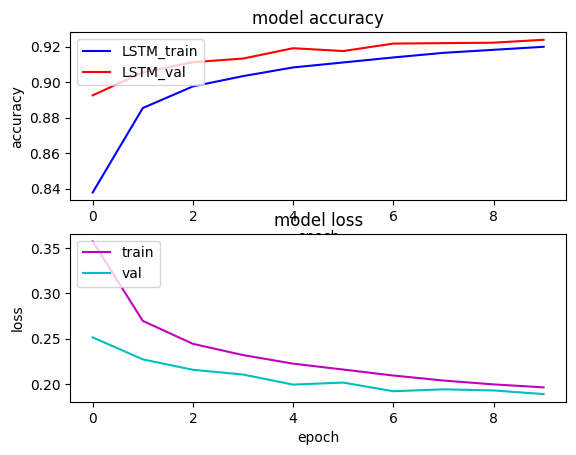

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

4/4 [==============================] - 2s 235ms/step


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

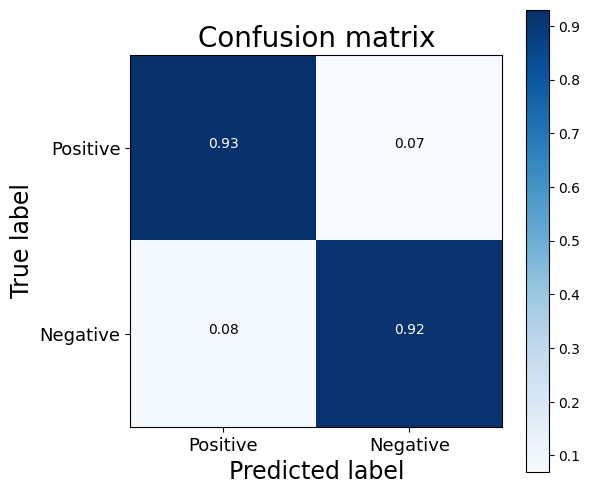

In [ ]:
cnf_matrix = confusion_matrix(df_test.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_test.sentiment.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(df_test.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.92      0.93      0.92     19000
    Positive       0.93      0.92      0.92     19000

    accuracy                           0.92     38000
   macro avg       0.92      0.92      0.92     38000
weighted avg       0.92      0.92      0.92     38000

